### Test - Synthetic Diagnostic + Interferometry

</b> Author:   </b>  Louis Evans     </br>
</b> Reviewer: </b>  Stefano Merlini

### Import relevant files:

In [65]:
%matplotlib widget
import numpy as np
import vtk
from vtk.util import numpy_support as vtk_np
import matplotlib.pyplot as plt
import gc

import sys

#add path
sys.path.insert(0, '../../synthPy_restructured')     # import path/to/synthpy

import beam as beam_initialiser
import diagnostics as diag
import domain as d
import propagator as p
import utils

import importlib
importlib.reload(beam_initialiser)
importlib.reload(diag)
importlib.reload(d)
importlib.reload(p)
importlib.reload(utils)

RuntimeError: 'widget is not a recognised GUI loop or backend name

To use the ray tracer, first create a 'domain', load the domain with an electron distribution, calculate electron gradients, initialise a beam, and solve!
\
\
The output can either be plotted, or passed further through ray optics for synthetic diagnostics

In [ ]:
# define some extent, the domain should be distributed as +extent to -extent, does not need to be cubic
extent_x = 5e-3
extent_y = 5e-3
extent_z = 10e-3

n_cells = 100

#x = np.linspace(-extent_x, extent_x, n_cells)
#y = np.linspace(-extent_y, extent_y, n_cells)
#z = np.linspace(-extent_z, extent_z, n_cells)

probing_extent = extent_z
probing_direction = 'z'

lengths = 2 * np.array([extent_x, extent_y, extent_z])

print("Garbage collection count:", gc.collect())

#domain = d.ScalarDomain(x = x, y = y, z = z, extent= probing_extent, probing_direction = probing_direction)     # create domain
# Much simpler domain function, no longer needlessly takes in beam values, they are fully seperated
domain = d.ScalarDomain(lengths, n_cells) # B_on = False by default

# clear we should do manual garbage collection of some variety in d.ScalarDomain function
print("Garbage collection count:", gc.collect())

Garbage collection count: 4073
Garbage collection count: 0


Load some domain distribution

In [ ]:
# load some external pvti
# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)
# or load a test distribution

#domain.ne = np.full((100, 100, 100), 1e24)
#domain.test_exponential_cos()
domain.josie_test(radius = 2e-3, position = (0,0), n1 = 1, n2 = 1.2)

#domain.test_slab(0.000001, 1e24)
domain.external_Te(np.full((n_cells, n_cells, n_cells), 2e5))
domain.external_mass_density(np.full((n_cells, n_cells, n_cells), 2e3))

Solve gradients, initialise beam, and solve

In [ ]:
wl = 1064e-9 #define laser wavelength

# initialise beam
Np = 50  # number of photons
divergence = 5e-5   # realistic divergence value
beam_size = extent_x    # beam radius
ne_extent = probing_extent  # so the beam knows where to initialise initial positions
beam_type = 'circular'

initial_rays = beam_initialiser.Beam(Np, beam_size, divergence, ne_extent, probing_direction, wl, beam_type)
tracer = p.Propagator(domain, initial_rays, inv_brems = False, x_ray = False, phaseshift = False, refrac_field = True, elec_density = False)
# solve ray trace
tracer.calc_dndr()
tracer.set_up_interps()

final_rays = tracer.solve(parallelise = True, jitted = True, Nt = 100, Ntrack = 10)
times = tracer.t
positions = tracer.Beam.positions
amplitudes = tracer.Beam.amplitudes
#print("phase shift from derivative:", tracer.Beam.phases[:, -1])


#final_rays, final_rays_to_Jonesvector = tracer.Beam.rf, tracer.Beam.Jf
print("\nCompleted ray trace in", np.round(tracer.duration, 3), "seconds.")

hi
jax compilation of solver took: 0.0
phase shift from line integral: 0

Parallelised output has resulting 3D matrix of form: [batch_count, 2, 9]: (50, 100, 9)
	2 to account the start and end results
	9 containing the 3 position and velocity components, amplitude, phase and polarisation

We reshape into the form: (9, 50)

Completed ray trace in 2.258 seconds.


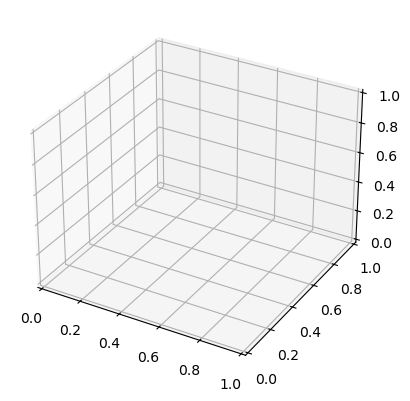

In [ ]:
axes1 = plt.axes(projection = "3d")
#print(domain.refrac_field)
#plt.plot(domain.ZZ[:,0,:], domain.XX[:,0,:], domain.refrac_field[:,0,:], ".")
#axes1.plot(domain.ZZ[:,0,:], domain.XX[:,0,:], tracer.dndz_interp(()), ".")

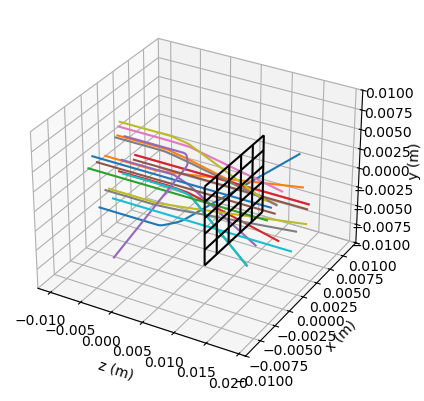

In [ ]:
axes = plt.axes(projection = "3d")
num_rays = 20
subset_rays = positions[np.random.randint(low = Np, size = num_rays)]
for i in subset_rays:
   
    x, y, z = zip(*i)
    plt.plot(z, x, y)
    
x_plane = np.linspace(-0.005, 0.005, 100)
y_plane = np.linspace(-0.005, 0.005, 100)
xx, yy =np.meshgrid(x_plane, y_plane)
z_plane = np.full(100, 0.01)
axes.plot_wireframe(z_plane, xx, yy, rcount = 5, ccount = 5, color="k")
axes.set_ylim(-10e-3, 10e-3)
axes.set_zlim(-10e-3, 10e-3)
axes.set_xlabel('z (m)')
axes.set_ylabel('x (m)')
axes.set_zlabel('y (m)')
plt.show()

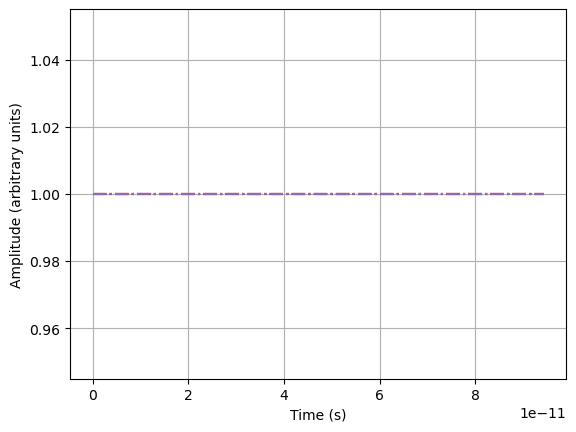

In [ ]:
num_rays = 5
subset_rays = amplitudes[np.random.randint(low = Np, size=num_rays)]
for i in subset_rays:
    plt.plot(times, i, "-.")
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (arbitrary units)")
plt.yscale("linear")
plt.show()


r0 after clearing nan's: (50, 50)


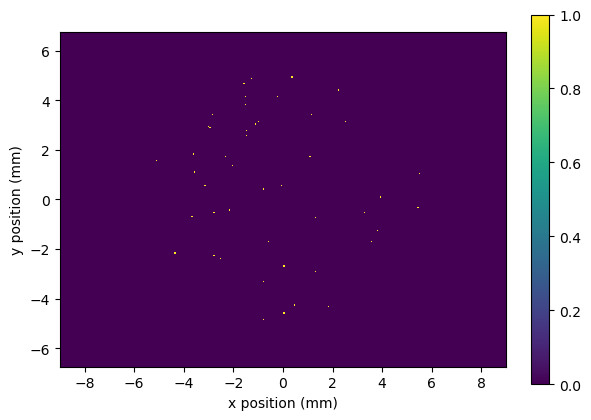

In [ ]:
fig, ax = plt.subplots()
tracer.Beam.rf = tracer.Beam.rf*1e3
diagnostic=diag.Diagnostic(tracer.Beam)
diagnostic.histogram(bin_scale=10, clear_mem=True)
diagnostic.plot(ax)
tracer.Beam.rf = tracer.Beam.rf*1e-3

Pass through ray optics: For Shadowgaphy, Schlieren, or Refractometry:


r0 after clearing nan's: (22, 22)
Garbage collection count: 18975


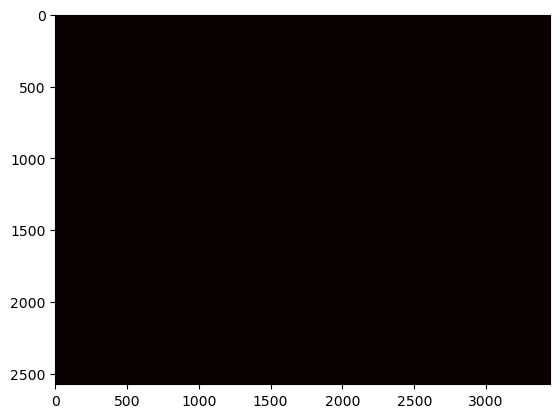

In [ ]:
#in the diagnostic initialisation, details on the lens configurations, and detector dimensions can be specified
refractometer = diag.Refractometry(tracer.Beam)
refractometer.incoherent_solve()
# cam't clear_mem if you want to generate other graphs afterwards
refractometer.histogram(bin_scale = 1, clear_mem = False)

#information accessed by .H(istogram) , e.g plt.imshow(refractometer.H)

#plt.imshow(refractometer.H, cmap='hot', interpolation='nearest', clim = (0, 2))
plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

print("Garbage collection count:", gc.collect())


r0 after clearing nan's: (22, 22)
Garbage collection count: 3053


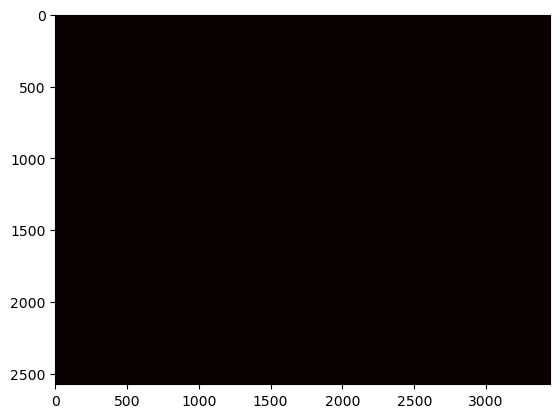

In [ ]:
shadowgrapher = diag.Shadowgraphy(tracer.Beam)
shadowgrapher.single_lens_solve()
shadowgrapher.histogram(bin_scale = 1, clear_mem = False)

plt.imshow(shadowgrapher.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

print("Garbage collection count:", gc.collect())

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]

r0 after clearing nan's: (0, 0)
Garbage collection count: 3065


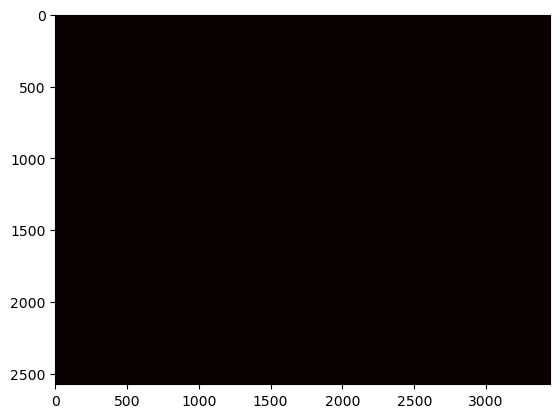

In [ ]:
schlierener = diag.Schlieren(tracer.Beam)
schlierener.DF_solve()
schlierener.histogram(bin_scale = 1, clear_mem = True)

plt.imshow(schlierener.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

print("Garbage collection count:", gc.collect())

Synthetic Interferometry - This requires some extra steps in the ray tracing to include information on the phase and electric field values

In [ ]:
# No need to change the domain (now that code has been seperated out in restructure)



# load some external pvti

# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)

# or load a test distribution



# initialise beam


# solve ray trace
tracer = p.Propagator(domain, initial_rays, inv_brems = False, phaseshift = False, x_ray = False)

tracer.calc_dndr()
tracer.set_up_interps()
tracer.Beam.rf, tracer.Beam.Jf = tracer.solve(parallelise = False, jitted = False, return_E = True)

n_fringes = 10
deg = 10 #adjust number of fringes and tilt in degrees from the vertical exis
print('hi')
interferometrer = diag.Interferometry(tracer.Beam)
interferometrer.interfere_ref_beam(n_fringes, deg)

pattern = diag.Interferometry(tracer.Beam)
#pattern = interferometrer
pattern.two_lens_solve()
pattern.interferogram(bin_scale = 1, clear_mem = True) #use interferogram instead of histogram

#get interferogram histogram with sh.H


AttributeError: 'ScalarDomain' object has no attribute 'ne'

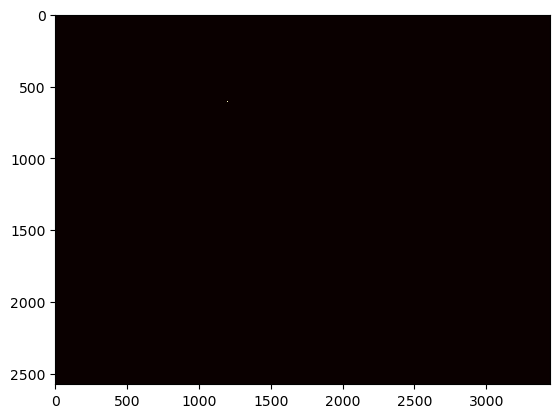

In [ ]:
plt.imshow(pattern.H, cmap = 'hot', interpolation = 'nearest')